In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../data/interim/clean_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 123 entries, has_null to match
dtypes: float64(59), int64(60), object(4)
memory usage: 7.9+ MB


<b>Create an index for each person</b>

According to the dataset documentation, each observation is a date between two people. We think it might be interesting to add an identifier to each person to see how many dates that person has had. This identifier has been created by joining all the attributes that correspond to the person who has the date and leaving out the attributes of the partner.

In [2]:
def index(df):
    return df['gender']+str(df['age'])+df['race']+df['field']+str(df['attractive_important'])+str(df['sincere_important'])+str(df['intellicence_important'])+str(df['funny_important'])+str(df['ambtition_important'])+str(df['attractive'])+str(df['sincere'])+str(df['intelligence'])+str(df['funny'])+str(df['ambition'])+str(df['sports'])+str(df['tvsports'])+str(df['exercise'])+str(df['dining'])+str(df['museums'])+str(df['art'])+str(df['hiking'])+str(df['gaming'])+str(df['clubbing'])+str(df['reading'])+str(df['tv'])+str(df['theater'])+str(df['movies'])+str(df['concerts'])+str(df['music'])+str(df['shopping'])+str(df['yoga'])


df['index_id'] = df.apply(lambda row : index(row), axis = 1)

dict_ids = {}

i=1
for id in df.index_id.unique():
        dict_ids[id] = i
        i=i+1

df['person_id'] = df['index_id'].map(dict_ids)
del df["index_id"]

## Investigating Outliers

In [3]:
# 55 year old woman
df.loc[df['age'] == 55,['age']] = np.nan
df.loc[df['age_o'] == 55,['age_o']] = np.nan

# gaming and reading above 10
df.loc[df['gaming'] == 14,['gaming']] = np.nan
df.loc[df['reading'] == 13,['reading']] = np.nan

## Inspecting Missing Values

#### Key Findings:
- 1.78% missing values globally
- only 4 attributes have over 10% missing observations
    - expected_num_interested_in_me     
    - expected_num_matches 
    - shared_interests_o     
    - shared_interests_partner
- an extra 15 attributes have over 1% missing observations

In [4]:
## ---*--- Global ---*---
## 

global_missing = round( 100 * (df.isnull().sum().sum() / (8378 * 123)), 2) # total NA / size of df
print('{}% missing values globally'.format(global_missing))

if global_missing < 2:
    print('nice...\n')

## ---*--- By Attribute ---*---
## 

# filling dict as {'column_name': [total NA, percentage NA]}
missing_dict = {col: [df[col].isnull().sum(), round(df[col].isnull().sum() / len(df[col]), 4) * 100] for col in df}
# fancy method to sort dictionary descending by value
missing_dict = dict(sorted(missing_dict.items(), key=lambda x:x[1], reverse=True))

# output 'pretty format' partial results
print('{:<32} {:<10} {:<10}'.format('attribute', 'total NA', '% NA'))
print('{:<32} {:<10} {:<10}'.format('-'*31, '-'*9, '-'*6))
for key, value in missing_dict.items():
    if value[0] != 0:
        print('{:<32} {:<10} {} %'.format(key, value[0], round(value[1], 1)))

1.78% missing values globally
nice...

attribute                        total NA   % NA      
-------------------------------  ---------  ------    
expected_num_interested_in_me    6578       78.5 %
expected_num_matches             1173       14.0 %
shared_interests_o               1076       12.8 %
shared_interests_partner         1067       12.7 %
ambitous_o                       722        8.6 %
ambition_partner                 712        8.5 %
met                              375        4.5 %
funny_o                          360        4.3 %
funny_partner                    350        4.2 %
guess_prob_liked                 309        3.7 %
intelligence_o                   306        3.6 %
intelligence_partner             296        3.5 %
sinsere_o                        287        3.4 %
sincere_partner                  277        3.3 %
like                             240        2.9 %
attractive_o                     212        2.5 %
attractive_partner               202        2.4

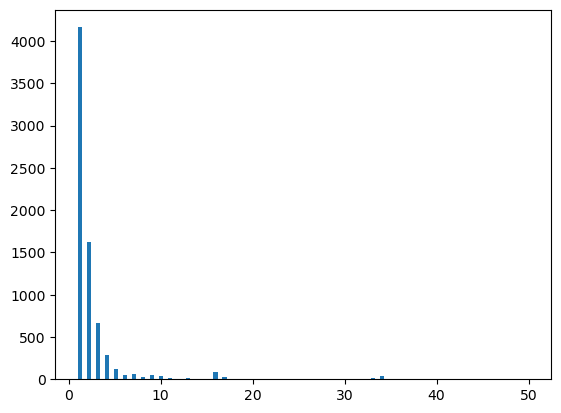

In [5]:
# ---*--- By Observation ---*---

# sum of global missing values 
df['has_null'].sum()
# new attribute with count of missing values in each row
df['nulls_byRow'] = df.isnull().sum(axis=1)

# plot histogram of df['null_byRow']
plt.hist(df.nulls_byRow[df['nulls_byRow'] != 0], bins = 100);
#df['nulls_byRow'].value_counts()

In [6]:
## ---*--- Reducing variability of 'field' attribute ---*---
##

def fix_field(og_field):
    for key, value in field_dict.items():
        if og_field.lower() in value:
            return key

field_dict = {
    'law': ['law', 'law and social work', 'law and english literature [j.d./ph.d.]', 'intellectual property law', 'law/business'],
    'business': ['business', 'business [mba]', 'business- mba', 'international business', 'marketing', 'international relations', 'business; marketing', 'mba', 'public administration', 'master in public administration', 'masters in public administration', 'business/ finance/ real estate', 'business/law', 'business school', 'business administration', 'business consulting', 'business; media', 'fundraising management', 'business [finance & marketing]', 'mba - private equity / real estate', 'general management/finance'],
    'mathematics': ['mathematics', 'statistics', 'math', 'mathematics; phd', 'operations research', 'operations research [seas]', 'math education', 'ma in quantitative methods', 'stats', 'math of finance'],
    'finance': ['finance','finanace', 'mathematical finance', 'finance&economics', 'international finance; economic policy', 'financial math', 'international finance and business', 'finance/economics', 'mba finance', 'financial engineering'],
    'architecture': ['architecture', 'urban planning'],
    'engineering': ['electrical engineering', 'engineering', 'computer science', 'biomedical engineering', 'mechanical engineering', 'industrial engineering', 'electrical engg.', 'environmental engineering', 'industrial engineering/operations research', 'masters of industrial engineering'],
    'physics': ['marine geophysics', 'physics', 'physics [astrophysics]'],
    'biology': ['microbiology', 'biology', 'cell biology', 'ma biotechnology', 'neurobiology','neuroscience', 'conservation biology', 'biotechnology', 'genetics', 'molecular biology', 'genetics & development', 'biomedical informatics', 'neurosciences/stem cells', 'biology phd', 'biochemistry/genetics', 'biochemistry & molecular biophysics'],
    'chemistry': ['chemistry', 'biochemistry', 'computational biochemsistry'],
    'anthropology': ['museum anthropology', 'anthropology'], 
    'environmental science': ['climate-earth and environ. science', 'climate change', 'ecology', 'earth and environmental science', 'climate dynamics'],
    'political science': ['political science', 'business & international affairs', 'international affairs', 'international affairs/finance', 'international affairs - economic development', 'international affairs/international finance', 'international affairs and public health','business and international affairs [mba/mia dual degree]', 'international affairs/business', 'master of international affairs', 'international politics', 'mba / master of international affairs [sipa]', 'sipa / mia', 'international security policy - sipa', 'intrernational affairs', 'international affairs - economic policy', 'sipa - energy', 'public policy', 'human rights: middle east', 'human rights', 'sipa-international affairs', 'social work/sipa'],
    'sociology': ['social work', 'masters of social work', 'sociology', 'economics; sociology', 'qmss', 'international development', 'sociology and education', 'american studies', 'african-american studies/history'],
    'economics': ['applied maths/econs', 'economics', 'money', 'economics; english',  'economics and political science'],
    'psychology': ['psychology', 'psychology and english', 'clinical psychology', 'educational psychology', 'organizational psychology', 'school psychology', 'counseling psychology'],
    'medicine': ['medicine', 'medical informatics', 'biomedicine', 'epidemiology', 'gs postbacc premed', 'medicine and biochemistry'],
    'health': ['nutritiron', 'nutrition/genetics', 'sociomedical sciences- school of public health', 'tc [health ed]', 'health policy', 'nutrition', 'applied physiology & nutrition', 'public health'],
    'art': ['film', 'art history/medicine', 'art education', 'arts administration', 'art history', 'mfa -film', 'theatre management & producing', 'gsas', 'theater', 'mfa acting program', 'acting'],
    'education': ['elementary/childhood education [ma]', 'international educational development', 'education administration', 'masters of social work&education', 'speech language pathology', 'speech languahe pathology', 'elementary education', 'ma science education', 'social studies education', 'ma teaching social studies', 'education policy', 'education- literacy specialist', 'anthropology/education', 'bilingual education', 'education', 'tesol', 'cognitive studies in education', 'curriculum and teaching/giftedness', 'english education', 'early childhood education', 'ed.d. in higher education policy at tc', 'music education', 'communications in education', 'higher ed. - m.a.', 'neuroscience and education', 'elementary education - preservice', 'education leadership - public school administration', 'teaching of english'],
    'literature': ['german literature','classics', 'polish', 'english and comp lit','english', 'mfa creative writing', 'comparative literature', 'modern chinese literature', 'japanese literature', 'french', 'creative writing', 'creative writing - nonfiction', 'writing: literary nonfiction', 'creative writing [nonfiction]', 'nonfiction writing', 'mfa writing', 'mfa  poetry', 'soa -- writing'],
    'philosophy': ['philosophy [ph.d.]', 'philosophy and physics', 'philosophy'],
    'communications': ['speech pathology', 'instructional tech & media', 'instructional media and technology', 'journalism', 'communications'],
    'history': ['history', 'history [gsas - phd]', 'american studies [masters]'],
    'religion': ['religion', 'history of religion', 'religion; gsas'],
    'other/job': ['working', 'consulting', 'undergrad - gs', 'theory', '?']
}
            
df.field = df.field.apply(lambda x: fix_field(x))
df[df.field.isnull()].field # verify

Series([], Name: field, dtype: object)

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
import xgboost

# dropping 'expected_num_interested_in_me' attribute with ~80% missing values
df.drop('expected_num_interested_in_me', axis=1, inplace=True)
# dropping all observations with 10 or more missing values (approx. )
df = df[df['nulls_byRow'] < 10]

# generate binary values using get_dummies
pre_oneHot_df = pd.get_dummies(df, columns=['gender', 'race', 'race_o', 'field'])

# instantiating iterative imputer
imp = IterativeImputer(estimator=linear_model.BayesianRidge(),
        #estimator=xgboost.XGBRegressor(
        #n_estimators=7,
        #random_state=42,
        #tree_method='auto'
        #),
    missing_values=np.nan,
    max_iter=10,
    initial_strategy='mean',
    imputation_order='ascending',
    n_nearest_features=None,
    verbose=2,
    random_state=42
)

oneHot_df = pd.DataFrame(imp.fit_transform(pre_oneHot_df), columns=pre_oneHot_df.columns)
oneHot_df.shape

[IterativeImputer] Completing matrix with shape (8102, 158)
[IterativeImputer] Ending imputation round 1/10, elapsed time 50.23
[IterativeImputer] Change: 42.98822494709849, scaled tolerance: 0.547 
[IterativeImputer] Ending imputation round 2/10, elapsed time 100.30
[IterativeImputer] Change: 5.892403845395776, scaled tolerance: 0.547 
[IterativeImputer] Ending imputation round 3/10, elapsed time 209.95
[IterativeImputer] Change: 5.003059313556356, scaled tolerance: 0.547 
[IterativeImputer] Ending imputation round 4/10, elapsed time 262.02
[IterativeImputer] Change: 4.027358216452349, scaled tolerance: 0.547 
[IterativeImputer] Ending imputation round 5/10, elapsed time 312.51
[IterativeImputer] Change: 3.094083099172437, scaled tolerance: 0.547 
[IterativeImputer] Ending imputation round 6/10, elapsed time 362.02
[IterativeImputer] Change: 2.254198067765749, scaled tolerance: 0.547 
[IterativeImputer] Ending imputation round 7/10, elapsed time 419.77
[IterativeImputer] Change: 1.694

/Users/efwerr/miniforge3/envs/aml_env/lib/python3.11/site-packages/sklearn/impute/_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/var/folders/hd/rpm_8j3d44n1dqt00dv0sps00000gn/T/ipykernel_9237/1202005177.py:31: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  oneHot_df[:] = imp.fit_transform(oneHot_df)


(8102, 158)

In [40]:
oneHot_df.round(1)

,has_null,wave,age,age_o,d_age,d_d_age,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,attractive,sincere,intelligence,funny,ambition,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match,person_id,nulls_byRow,gender_female,gender_male,race_Asian/Pacific Islander/Asian-American,race_Black/African American,race_European/Caucasian-American,race_Latino/Hispanic American,race_Other,race_o_?,race_o_Asian/Pacific Islander/Asian-American,race_o_Black/African American,race_o_European/Caucasian-American,race_o_Latino/Hispanic American,race_o_Other,field_anthropology,field_architecture,field_art,field_biology,field_business,field_chemistry,field_communications,field_economics,field_education,field_engineering,field_environmental science,field_finance,field_health,field_history,field_law,field_literature,field_mathematics,field_medicine,field_other/job,field_philosophy,field_physics,field_political science,field_psychology,field_religion,field_sociology
0,0.0,1.0,21.0,27.0,6.0,2.0,0.0,2.0,4.0,1.0,1.0,35.0,20.0,20.0,20.0,0.0,5.00,2.0,1.0,1.0,1.0,0.0,0.0,6.0,8.0,8.0,8.0,8.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,15.0,20.0,20.0,15.0,15.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0,6.0,8.0,8.0,8.0,7.0,1.0,1.0,1.0,1.0,1.0,6.0,9.0,7.0,7.0,6.00,5.00,1.0,2.0,1.0,1.0,1.0,0.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,0.14,0.0,3.0,4.0,0.0,0.0,1.0,7.0,6.00,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,21.0,22.0,1.0,0.0,0.0,2.0,4.0,1.0,1.0,60.0,0.0,0.0,40.0,0.0,0.00,2.0,0.0,0.0,2.0,0.0,0.0,7.0,8.0,10.0,7.0,7.0,5.0,1.0,1.0,2.0,1.0,1.0,0.0,15.0,20.0,20.0,15.0,15.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0,6.0,8.0,8.0,8.0,7.0,1.0,1.0,1.0,1.0,1.0,7.0,8.0,7.0,8.0,5.00,6.00,1.0,1.0,1.0,1.0,0.0,1.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,0.54,1.0,3.0,4.0,0.0,0.0,1.0,7.0,5.00,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,21.0,22.0,1.0,0.0,1.0,2.0,4.0,1.0,1.0,19.0,18.0,19.0,18.0,14.0,12.00,1.0,1.0,1.0,1.0,0.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,2.0,2.0,2.0,2.0,2.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0,6.0,8.0,8.0,8.0,7.0,1.0,1.0,1.0,1.0,1.0,5.0

In [46]:
import warnings
warnings.filterwarnings("ignore")

id_variables =['age','attractive_important','sincere_important','intellicence_important',
'funny_important','ambtition_important','attractive','sincere','intelligence','funny','ambition','sports','tvsports',
'exercise','dining','museums','art','hiking','gaming','clubbing','reading','tv','theater','movies','concerts','music',
'shopping','yoga']

df_final = pd.DataFrame()

for id in oneHot_df.person_id.unique():
    df_id = oneHot_df[oneHot_df['person_id']==id]
    for variable in id_variables:
        df_id[variable] = round(df_id[variable].mean(),0);
    df_final = pd.concat([df_final, df_id])

In [47]:
df_final = df_final.round(2)
df_final.to_csv('../data/processed/processed_data.csv', index=False)

In [48]:
df_final.describe()

,has_null,wave,age,age_o,d_age,d_d_age,samerace,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,d_pref_o_funny,d_pref_o_ambitious,d_pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,d_attractive_o,d_sinsere_o,d_intelligence_o,d_funny_o,d_ambitous_o,d_shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,d_attractive_important,d_sincere_important,d_intellicence_important,d_funny_important,d_ambtition_important,d_shared_interests_important,attractive,sincere,intelligence,funny,ambition,d_attractive,d_sincere,d_intelligence,d_funny,d_ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,d_attractive_partner,d_sincere_partner,d_intelligence_partner,d_funny_partner,d_ambition_partner,d_shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,d_sports,d_tvsports,d_exercise,d_dining,d_museums,d_art,d_hiking,d_gaming,d_clubbing,d_reading,d_tv,d_theater,d_movies,d_concerts,d_music,d_shopping,d_yoga,interests_correlate,d_interests_correlate,expected_happy_with_sd_people,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match,person_id,nulls_byRow,gender_female,gender_male,race_Asian/Pacific Islander/Asian-American,race_Black/African American,race_European/Caucasian-American,race_Latino/Hispanic American,race_Other,race_o_?,race_o_Asian/Pacific Islander/Asian-American,race_o_Black/African American,race_o_European/Caucasian-American,race_o_Latino/Hispanic American,race_o_Other,field_anthropology,field_architecture,field_art,field_biology,field_business,field_chemistry,field_communications,field_economics,field_education,field_engineering,field_environmental science,field_finance,field_health,field_history,field_law,field_literature,field_mathematics,field_medicine,field_other/job,field_philosophy,field_physics,field_political science,field_psychology,field_religion,field_sociology
count,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.00000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.000000,8102.0

In [5]:
import scipy as spy
import random

In [5]:
attractive_o_NA = df.attractive_o[df['expected_num_interested_in_me'].isnull()].dropna()
attractive_o_notNA = df.attractive_o[df['expected_num_interested_in_me'].isnull() == False].dropna()

attractive_NA = df.attractive[df['expected_num_interested_in_me'].isnull()].dropna()
attractive_notNA = df.attractive[df['expected_num_interested_in_me'].isnull() == False].dropna()

#attractive_NA = df.attractive_o[df['expected_num_interested_in_me'].isnull()].dropna()
#attractive_notNA = df.attractive_o[df['expected_num_interested_in_me'].isnull() == False].dropna()

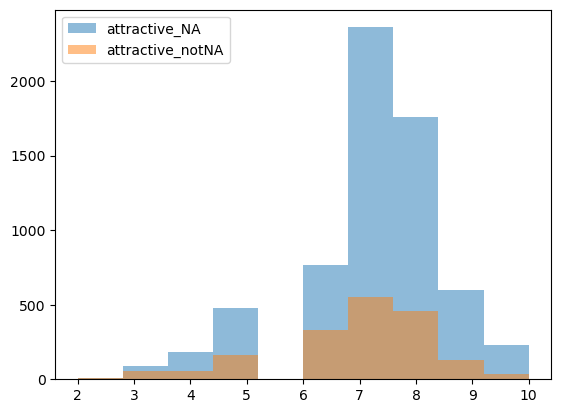

In [6]:
plt.hist(attractive_NA, bins=10, alpha=0.5, label='attractive_NA')
plt.hist(attractive_notNA, bins=10, alpha=0.5, label='attractive_notNA')
plt.legend(loc='upper left')
plt.show()

In [7]:
spy.stats.ttest_ind(attractive_NA, attractive_notNA)

Ttest_indResult(statistic=7.962484167295675, pvalue=1.9100828933031984e-15)

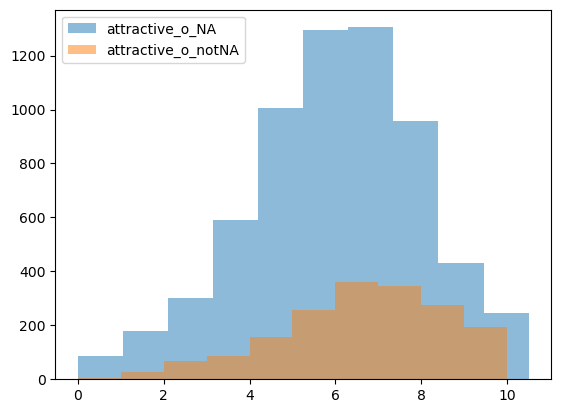

In [8]:
plt.hist(attractive_o_NA, bins=10, alpha=0.5, label='attractive_o_NA')
plt.hist(attractive_o_notNA, bins=10, alpha=0.5, label='attractive_o_notNA')
plt.legend(loc='upper left')
plt.show()

In [9]:
spy.stats.ttest_ind(attractive_o_NA, attractive_o_notNA)

Ttest_indResult(statistic=0.38595363399140564, pvalue=0.699541064841768)

## Missingness Mechanism

In [10]:
from pandas.api.types import is_numeric_dtype

def na_mechanism(df):
    '''
    
    '''
    na_mechanism_dict = {}
    for col1 in df.columns:

        if is_numeric_dtype(df[col1]):
            t_test_results = []
            for col2 in df.columns:

                if (df[col1].isnull().sum() != 0) and (df[col2].isnull().sum() != 0):
                    if is_numeric_dtype(df[col2]):
                        x = df[col2][df[col1].isnull()].dropna()
                        y = df[col2][df[col1].isnull() == False].dropna()
                        
                        # calculate t-test and append to t_test_results
                        ttest = spy.stats.ttest_ind(x, y)
                        if ttest[1] > 0.10:
                            t_test_results.append('{}: reject_null'.format(col2))
                        else:
                            t_test_results.append('{}: fail'.format(col2))
                    
                    else:
                        t_test_results.append('{}: not_numeric'.format(col2))
                
                # fill na_mechanism_dict as (k) = col1_name and (v) = t_test_results for each col2
                na_mechanism_dict[col1] = t_test_results
        
        else:
            na_mechanism_dict[col1] = ['not_numeric']

    return na_mechanism_dict

na_mechanism_dict = na_mechanism(df)

/var/folders/hd/rpm_8j3d44n1dqt00dv0sps00000gn/T/ipykernel_6845/2572861740.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = spy.stats.ttest_ind(x, y)


In [11]:
new_dict = {}
for key in na_mechanism_dict:
    new_dict[key] = 0
    for value in na_mechanism_dict[key]:
        if value[-4:] == 'null':
            new_dict[key] += 1

new_dict = dict(sorted(new_dict.items(), key=lambda x:x[1], reverse=True))
new_dict

{'sinsere_o': 42,
 'attractive_partner': 40,
 'sincere_partner': 40,
 'attractive_o': 39,
 'met': 39,
 'intelligence_o': 37,
 'intelligence_partner': 37,
 'like': 36,
 'ambitous_o': 34,
 'interests_correlate': 34,
 'shared_interests_o': 33,
 'pref_o_ambitious': 32,
 'funny_o': 32,
 'guess_prob_liked': 30,
 'pref_o_attractive': 29,
 'pref_o_sincere': 29,
 'pref_o_intelligence': 29,
 'age_o': 28,
 'pref_o_funny': 28,
 'ambition_partner': 28,
 'expected_happy_with_sd_people': 28,
 'funny_partner': 27,
 'ambtition_important': 26,
 'pref_o_shared_interests': 25,
 'age': 23,
 'shared_interests_partner': 23,
 'attractive': 21,
 'sincere': 21,
 'intelligence': 21,
 'funny': 21,
 'ambition': 21,
 'expected_num_interested_in_me': 20,
 'funny_important': 19,
 'importance_same_race': 18,
 'importance_same_religion': 18,
 'attractive_important': 18,
 'sincere_important': 18,
 'intellicence_important': 18,
 'sports': 18,
 'tvsports': 18,
 'exercise': 18,
 'dining': 18,
 'museums': 18,
 'art': 18,
 '

## Imputation

### KNN vs. MICE

In [14]:
'''from sklearn import linear_model

oneHot_df.drop(['expected_num_interested_in_me'], axis=1, inplace=True)

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), 
                                max_iter=30, 
                                n_nearest_features=None, 
                                imputation_order='ascending',
                                min_value=0,
                                random_state=42)

mice_df = pd.DataFrame(mice_imputer.fit_transform(oneHot_df), columns=oneHot_df.columns)'''

"from sklearn import linear_model\n\noneHot_df.drop(['expected_num_interested_in_me'], axis=1, inplace=True)\n\n# Define MICE Imputer and fill missing values\nmice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), \n                                max_iter=30, \n                                n_nearest_features=None, \n                                imputation_order='ascending',\n                                min_value=0,\n                                random_state=42)\n\nmice_df = pd.DataFrame(mice_imputer.fit_transform(oneHot_df), columns=oneHot_df.columns)"

In [26]:
## ---*--- Global ---*---
## 

global_missing = round( 100 * (df.isnull().sum().sum() / (8378 * 123)), 2) # total NA / size of df
print('{}% missing values globally'.format(global_missing))

if global_missing < 2:
    print('nice...\n')

## ---*--- By Attribute ---*---
## 

# filling dict as {'column_name': [total NA, percentage NA]}
missing_dict = {col: [df[col].isnull().sum(), round(df[col].isnull().sum() / len(df[col]), 4) * 100] for col in df}
# fancy method to sort dictionary descending by value
missing_dict = dict(sorted(missing_dict.items(), key=lambda x:x[1], reverse=True))

# output 'pretty format' partial results
print('{:<32} {:<10} {:<10}'.format('attribute', 'total NA', '% NA'))
print('{:<32} {:<10} {:<10}'.format('-'*31, '-'*9, '-'*6))
for key, value in missing_dict.items():
    if value[0] != 0:
        print('{:<32} {:<10} {} %'.format(key, value[0], round(value[1], 1)))

0.61% missing values globally
nice...

attribute                        total NA   % NA      
-------------------------------  ---------  ------    
expected_num_matches             1127       13.9 %
shared_interests_o               915        11.3 %
shared_interests_partner         880        10.9 %
ambitous_o                       565        7.0 %
ambition_partner                 525        6.5 %
funny_o                          209        2.6 %
met                              192        2.4 %
funny_partner                    165        2.0 %
intelligence_o                   155        1.9 %
sinsere_o                        135        1.7 %
guess_prob_liked                 124        1.5 %
intelligence_partner             111        1.4 %
pref_o_shared_interests          100        1.2 %
sincere_partner                  91         1.1 %
pref_o_ambitious                 80         1.0 %
age_o                            79         1.0 %
gaming                           77         1.0 

In [34]:
df.race_o.isnull().sum()

0